<a href="https://colab.research.google.com/github/zvyag/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-/blob/master/pytorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [0]:
transform = transforms.Compose([transforms.Resize((28, 28)), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)  # change the shape (1, 28, 28) -> (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

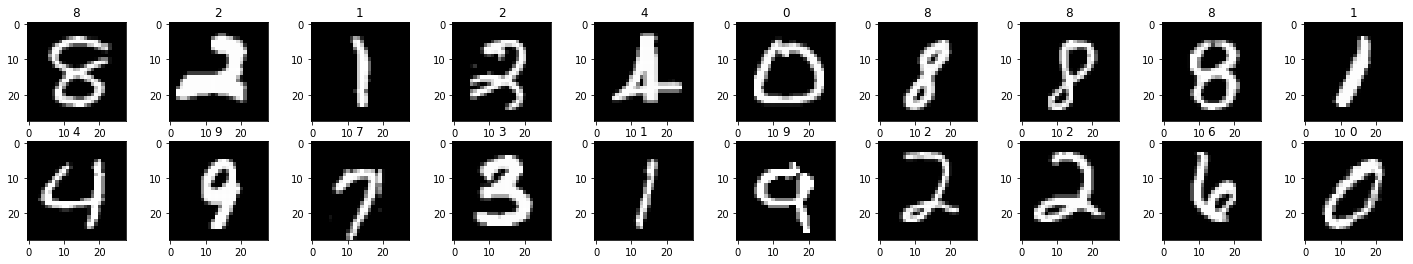

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)